# Audio Analysis

In [27]:
# link backend
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))
sys.path.append('/home/darkangel/ai-light-show/backend')
from backend.config import SONGS_TEMP_DIR, SONGS_DIR

# sample song 
song_name = 'fascination'
songs_folder = "/home/darkangel/ai-light-show/songs/"
song_file = f"{songs_folder}{song_name}.mp3"
print(f"song: {song_name} | {song_file}")

# load metadata
from backend.song_metadata import SongMetadata
song = SongMetadata(song_name=song_name, songs_folder=songs_folder)
print(f"song metadata: {song}")


song: fascination | /home/darkangel/ai-light-show/songs/fascination.mp3
song metadata: SongMetadata(song_name=fascination, title=fascination, genre=unknown, bpm=128.39, duration=401.798095703125, beats=857, arrangement=28)


In [28]:
from backend.ai.demucs_split import extract_stems
stems_folder = extract_stems(song_file)

drums_path = f"{stems_folder['output_folder']}/drums.wav"

🎵 Extracting stems from the song...


In [31]:
def get_suggested_threshold(features, step=10):
    """
    Estimate an optimal distance threshold for AgglomerativeClustering
    using Ward linkage and the KneeLocator algorithm.

    Args:
        features (np.ndarray): Frame-level feature matrix (e.g., Mel spectrogram.T).
        step (int): Downsampling step for faster processing (default=10).

    Returns:
        float or None: Suggested distance threshold, or None if no knee is found.
    """
    from scipy.cluster.hierarchy import linkage
    from kneed import KneeLocator
    import numpy as np

    # Step 1: Downsample feature frames
    features_sampled = features[::step]

    # Step 2: Hierarchical clustering (Ward method)
    Z = linkage(features_sampled, method='ward')
    merge_distances = Z[:, 2]

    # Step 3: Locate the elbow in the merge distances
    x = np.arange(len(merge_distances))
    knee = KneeLocator(x, merge_distances, curve='convex', direction='increasing')

    # Return the threshold or fallback
    return merge_distances[knee.knee] if knee.knee is not None else None


In [32]:
def cluster_and_export_segments(
    y, sr, threshold,
    output_dir="clusters",
    min_duration_sec=0.5,
    n_mels=64,
    fmax=8000,
    hop_length=2048
):
    """
    Cluster an audio signal based on mel-spectrogram similarity and export
    the first matching region for each cluster (if above a minimum duration).

    Args:
        y (np.ndarray): Audio waveform.
        sr (int): Sample rate.
        threshold (float): Distance threshold for AgglomerativeClustering.
        output_dir (str): Directory where cluster segments will be saved.
        min_duration_sec (float): Minimum duration (in seconds) for a region to be saved.
        n_mels (int): Number of mel bands in the spectrogram.
        fmax (int): Max frequency for mel scale.
        hop_length (int): Hop size for the spectrogram.

    Returns:
        tuple:
            - cluster_labels (np.ndarray): Cluster label for each spectrogram frame.
            - cluster_ranges (dict): Mapping {cluster_id: (start_time_sec, end_time_sec)}
    """
    import os
    from pathlib import Path
    import numpy as np
    import librosa
    import soundfile as sf
    from sklearn.cluster import AgglomerativeClustering

    # Patch deprecated numpy types (for compatibility)
    if not hasattr(np, 'complex'):
        np.complex = complex
    if not hasattr(np, 'float'):
        np.float = float

    Path(output_dir).mkdir(parents=True, exist_ok=True)

    # Extract features
    S = librosa.feature.melspectrogram(
        y=y, sr=sr, n_mels=n_mels, fmax=fmax, hop_length=hop_length
    )
    log_S = librosa.power_to_db(S, ref=np.max)
    features = log_S.T  # shape: (frames, n_mels)

    # Perform clustering
    clustering = AgglomerativeClustering(
        distance_threshold=threshold, n_clusters=None, linkage='ward'
    )
    cluster_labels = clustering.fit_predict(features)

    # Export one region per cluster
    cluster_ranges = {}
    for cluster_id in np.unique(cluster_labels):
        start_frame = None
        end_frame = None

        for i in range(len(cluster_labels)):
            if cluster_labels[i] == cluster_id:
                if start_frame is None:
                    start_frame = i
                end_frame = i
            elif start_frame is not None:
                break  # stop at first non-contiguous segment

        if start_frame is not None and end_frame is not None:
            start_sample = start_frame * hop_length
            end_sample = (end_frame + 1) * hop_length
            duration_sec = (end_sample - start_sample) / sr

            if duration_sec >= min_duration_sec:
                excerpt = y[start_sample:end_sample]
                out_path = Path(output_dir) / f"cluster_{cluster_id}.wav"
                sf.write(out_path, excerpt, sr)
                cluster_ranges[cluster_id] = (
                    round(start_sample / sr, 2),
                    round(end_sample / sr, 2)
                )

    return cluster_labels, cluster_ranges


In [33]:
import librosa

audio_path = drums_path  # Path to the audio file (e.g., drums.wav)

# Config
output_dir = "clusters"
min_duration_sec = 0.5
hop_length = 2048
n_mels = 64
fmax = 8000

# Load audio
y, sr = librosa.load(audio_path, sr=None)

# Compute features
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, fmax=fmax, hop_length=hop_length)
log_S = librosa.power_to_db(S, ref=np.max)
features = log_S.T

# Threshold suggestion
threshold = get_suggested_threshold(features)
print(f"Suggested distance_threshold = {threshold:.2f}")

# Cluster + export
cluster_labels, cluster_ranges = cluster_and_export_segments(
    y, sr, threshold,
    output_dir=output_dir,
    min_duration_sec=min_duration_sec,
    n_mels=n_mels,
    fmax=fmax,
    hop_length=hop_length
)

print(f"Discovered {len(set(cluster_labels))} clusters.")
print("Exported regions:", cluster_ranges)


Suggested distance_threshold = 242.86
Discovered 103 clusters.
Exported regions: {31: (0.0, 0.56)}


In [3]:
print(f"drums: {drums_path}")
import librosa
import numpy as np

y, sr = librosa.load(drums_path, sr=None)
y = y / np.max(np.abs(y))  # peak normalize

drums: /home/darkangel/ai-light-show/songs/temp/htdemucs/fascination/drums.wav


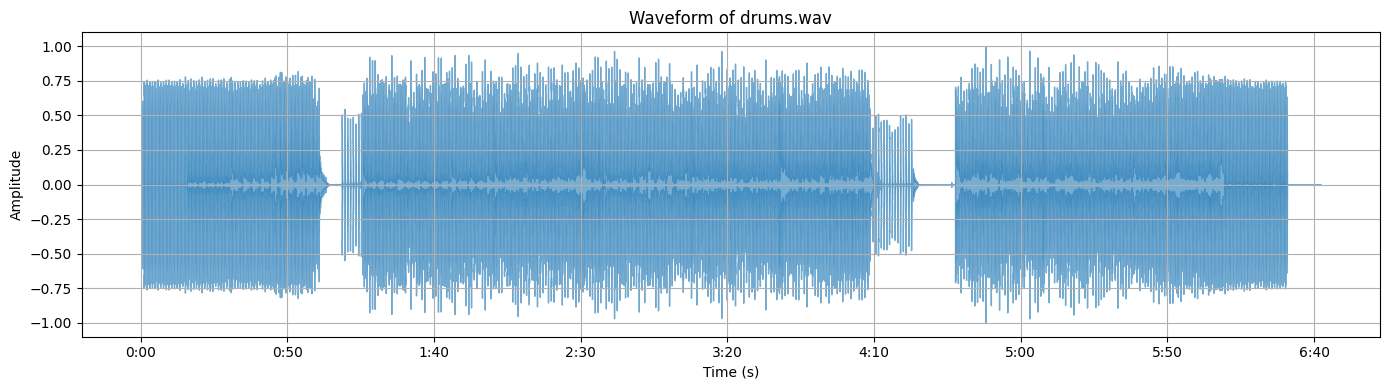

In [4]:
!pip install matplotlib --quiet
import matplotlib.pyplot as plt
import numpy as np

# 🔍 Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Waveform of drums.wav")
plt.xlabel("Time (s)")

num_points = len(y)
times = np.linspace(0, num_points / sr, num_points)
plt.ylabel("Amplitude")
plt.grid(True)
plt.tight_layout()
plt.show()

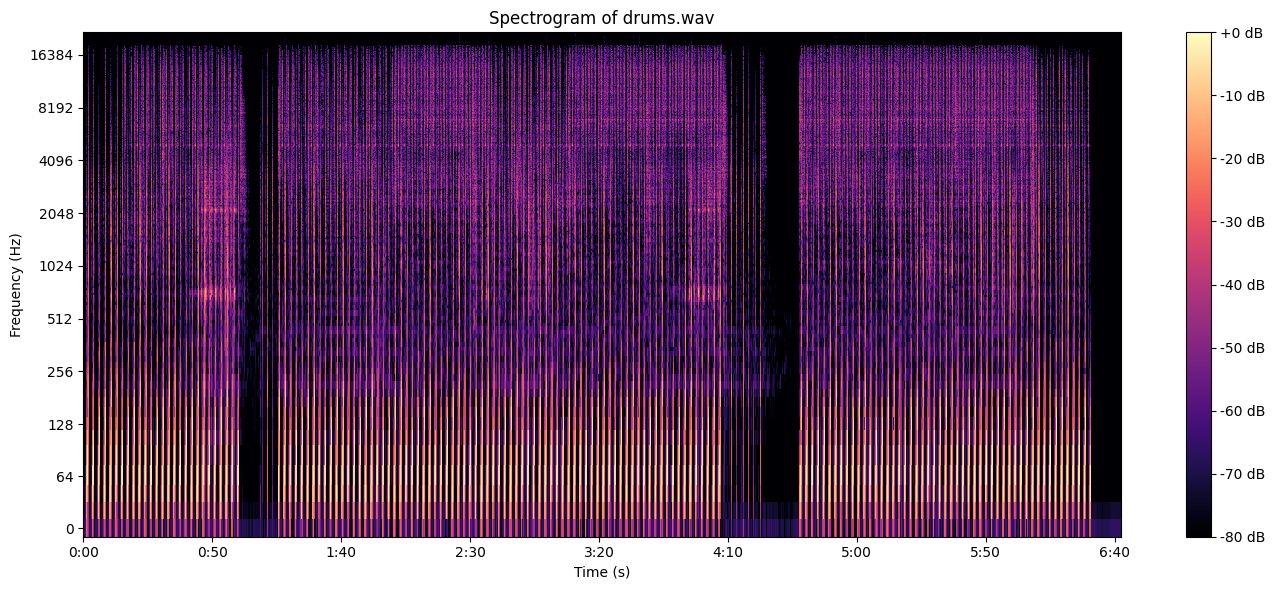

In [5]:
import matplotlib.pyplot as plt
import librosa.display

# Plot spectrogram
S = librosa.stft(y, n_fft=2048, hop_length=512)
S_db = librosa.amplitude_to_db(np.abs(S), ref=np.max)
plt.figure(figsize=(14, 6))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='log', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram of drums.wav')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.tight_layout()
plt.show()

In [6]:
from transformers import Wav2Vec2ForSequenceClassification, Wav2Vec2FeatureExtractor
import torch, librosa, numpy as np

model_name = "yojul/wav2vec2-base-one-shot-hip-hop-drums-clf"
feat = Wav2Vec2FeatureExtractor.from_pretrained(model_name)
model = Wav2Vec2ForSequenceClassification.from_pretrained(model_name)

y, sr = librosa.load(drums_path, sr=16000, mono=True)
window, hop = int(0.1*sr), int(0.05*sr)
events = []

for start in range(0, len(y)-window, hop):
    chunk = y[start:start+window]
    inputs = feat(chunk, sampling_rate=sr, return_tensors="pt")
    with torch.no_grad():
        logits = model(**inputs).logits
    probs = torch.softmax(logits, dim=-1).squeeze().cpu().numpy()
    label = model.config.id2label[np.argmax(probs)]
    conf = float(np.max(probs))
    if conf > 0.6:  # tune down if needed
        events.append({"time": (start+window/2)/sr, "type": label, "confidence": conf})

print(events[:10])


/home/darkangel/.pyenv/versions/3.10.17/envs/ai-light/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-07-05 00:16:11.492714: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-07-05 00:16:11.500883: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751685371.510753  129413 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751685371.513775  12

[{'time': 0.05, 'type': 'CYMBALS', 'confidence': 0.9541869759559631}, {'time': 0.1, 'type': 'CYMBALS', 'confidence': 0.9647868871688843}, {'time': 0.15, 'type': 'CYMBALS', 'confidence': 0.9581103920936584}, {'time': 0.2, 'type': 'CYMBALS', 'confidence': 0.9330190420150757}, {'time': 0.25, 'type': 'CYMBALS', 'confidence': 0.9434917569160461}, {'time': 0.3, 'type': 'CYMBALS', 'confidence': 0.9661393165588379}, {'time': 0.35, 'type': 'CYMBALS', 'confidence': 0.9604873061180115}, {'time': 0.4, 'type': 'CYMBALS', 'confidence': 0.9651082754135132}, {'time': 0.45, 'type': 'CYMBALS', 'confidence': 0.9552643299102783}, {'time': 0.5, 'type': 'CLAPS', 'confidence': 0.9145612120628357}]


In [7]:
# group events by type
drums_events = []
unique_types = set(e['type'] for e in events)
for t in unique_types:
    drums_events.append({
        "type": t,
        "time": [(e['time'], e['confidence']) for e in events if e['type'] == t]
        })

for e in drums_events:
    print(f"{e['type']}: {len(e['time'])} events")

808S: 1663 events
HITHATS: 894 events
CLAPS: 210 events
KICKS: 1377 events
SNARES: 543 events
CYMBALS: 1947 events


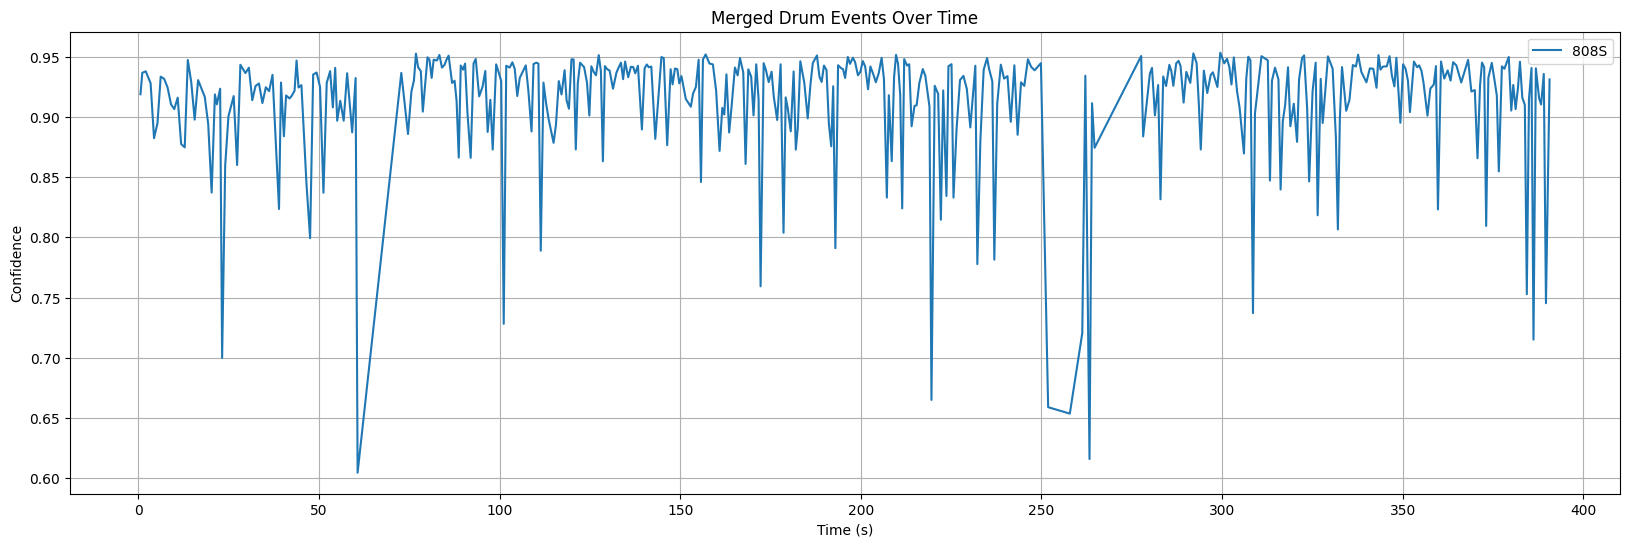

In [8]:
# merge events that are close in time, keep the one with highest confidence
# asume that an event shuld have a maximun duration of 0.5 seconds
max_duration = 0.5
merged_events = []
for e in drums_events:
    merged_time = []
    current_time = None
    current_confidence = 0.0
    
    for t, conf in sorted(e['time'], key=lambda x: x[0]):
        if current_time is None:
            current_time = t
            current_confidence = conf
        elif t - current_time <= max_duration:
            if conf > current_confidence:
                current_confidence = conf
        else:
            merged_time.append((current_time, current_confidence))
            current_time = t
            current_confidence = conf
            
    if current_time is not None:
        merged_time.append((current_time, current_confidence))
    
    merged_events.append({
        "type": e['type'],
        "time": merged_time
    })

# render only "kick"
plt.figure(figsize=(20, 6))
for e in [a for a in merged_events if a['type'] == '808S'] :
    times = [t[0] for t in e['time']]
    confs = [t[1] for t in e['time']]
    plt.plot(times, confs, label=e['type'])
plt.xlabel("Time (s)")
plt.ylabel("Confidence")
plt.title("Merged Drum Events Over Time")
plt.legend()
plt.grid()
plt.show()

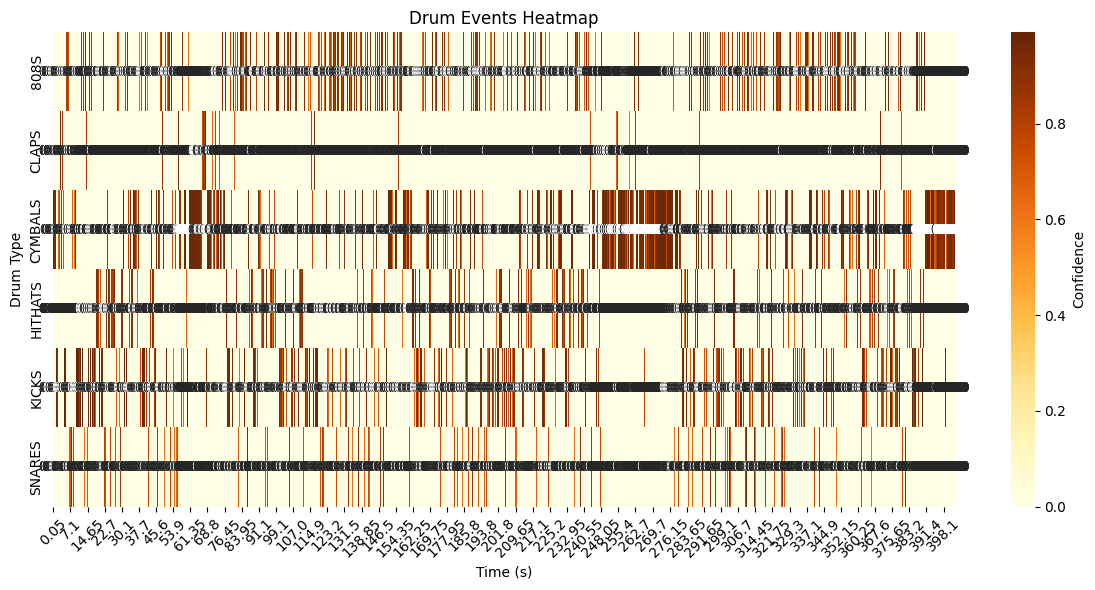

In [9]:
!pip install seaborn --quiet
import numpy as np
import pandas as pd

# Convert events to a DataFrame
df = pd.DataFrame(events)
pivot_df = df.pivot_table(index="type", columns="time", values="confidence", aggfunc="max", fill_value=0)
pivot_df

# Plot the heatmap
import seaborn as sns
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_df, cmap="YlOrBr", annot=True, fmt=".2f", cbar_kws={'label': 'Confidence'})
plt.title("Drum Events Heatmap")
plt.xlabel("Time (s)")
plt.ylabel("Drum Type")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

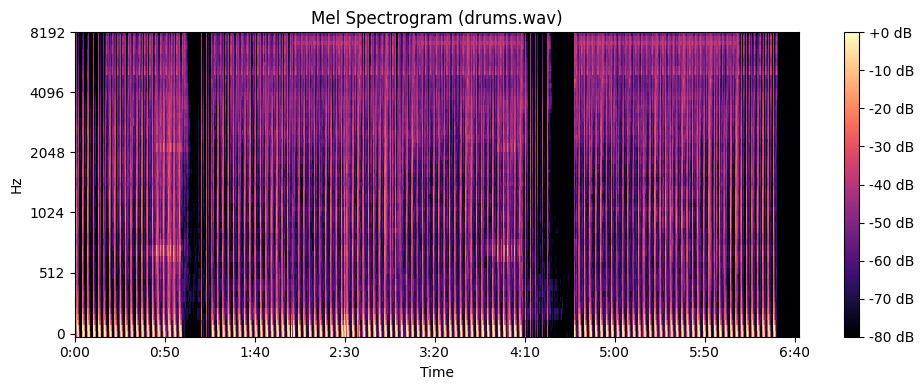

In [10]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

# Fix deprecated np.complex for compatibility with librosa
if not hasattr(np, 'complex'):
    np.complex = complex

# Compute Mel spectrogram
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000)
log_S = librosa.power_to_db(S, ref=np.max)

# Display Mel spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(log_S, sr=sr, x_axis='time', y_axis='mel', fmax=8000)
plt.colorbar(format='%+2.0f dB')
plt.title("Mel Spectrogram (drums.wav)")
plt.tight_layout()
plt.show()


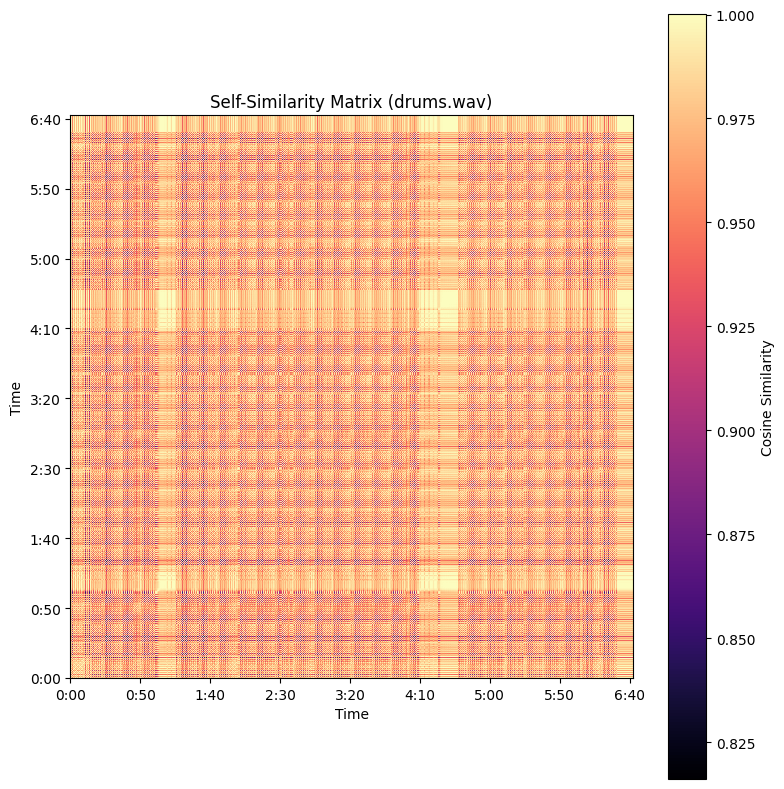

In [11]:
# Normalize columns of the spectrogram
norm_log_S = log_S / np.linalg.norm(log_S, axis=0, keepdims=True)

# Compute cosine similarity matrix
similarity_matrix = np.dot(norm_log_S.T, norm_log_S)


In [ ]:

# Plot self-similarity matrix
plt.figure(figsize=(8, 8))
librosa.display.specshow(similarity_matrix, x_axis='time', y_axis='time', sr=sr, hop_length=512)
plt.title("Self-Similarity Matrix (drums.wav)")
plt.colorbar(label='Cosine Similarity')
plt.tight_layout()
plt.show()


In [14]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering
import soundfile as sf  # for writing WAV files

def save_wav(filename, audio, sr):
    """Save audio to a WAV file."""
    sf.write(filename, audio, sr)

# Patch numpy for deprecated types
if not hasattr(np, 'complex'):
    np.complex = complex
if not hasattr(np, 'float'):
    np.float = float

# Compute Mel spectrogram
hop_length = 2048
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000, hop_length=hop_length)
log_S = librosa.power_to_db(S, ref=np.max)

# Cluster features
features = log_S.T
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = clustering.fit_predict(features)

# ---  Extract and save one excerpt per cluster ID ---
unique_clusters = np.unique(cluster_labels)

for cluster_id in unique_clusters:
    start_frame = None
    end_frame = None

    for i in range(len(cluster_labels)):
        if cluster_labels[i] == cluster_id:
            if start_frame is None:
                start_frame = i
            end_frame = i
        elif start_frame is not None:
            break  # first complete segment done

    if start_frame is not None and end_frame is not None:
        start_sample = start_frame * hop_length
        end_sample = (end_frame + 1) * hop_length
        excerpt = y[start_sample:end_sample]
        filename = f"{stems_folder['output_folder']}/drums_{cluster_id}.wav"
        save_wav(filename, excerpt, sr)
        print(f"Saved cluster {cluster_id} region to '{filename}'")
    else:
        print(f"Cluster {cluster_id} not found in data.")


Saved cluster 0 region to '/home/darkangel/ai-light-show/songs/temp/htdemucs/fascination/drums_0.wav'
Saved cluster 1 region to '/home/darkangel/ai-light-show/songs/temp/htdemucs/fascination/drums_1.wav'
Saved cluster 2 region to '/home/darkangel/ai-light-show/songs/temp/htdemucs/fascination/drums_2.wav'
Saved cluster 3 region to '/home/darkangel/ai-light-show/songs/temp/htdemucs/fascination/drums_3.wav'
Saved cluster 4 region to '/home/darkangel/ai-light-show/songs/temp/htdemucs/fascination/drums_4.wav'


In [15]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import linkage
from kneed import KneeLocator
import numpy as np

# Step 1: Subsample features for threshold estimation
step = 10
features_sampled = features[::step]

# Step 2: Linkage matrix and distance extraction
Z = linkage(features_sampled, method='ward')
merge_distances = Z[:, 2]

# Step 3: Use KneeLocator to find the elbow (threshold)
x = np.arange(len(merge_distances))
knee = KneeLocator(x, merge_distances, curve='convex', direction='increasing')
suggested_threshold = merge_distances[knee.knee] if knee.knee is not None else 20.0  # fallback

print(f"Using distance_threshold = {suggested_threshold:.2f}")

# Step 4: Full-resolution clustering using dynamic threshold
clustering = AgglomerativeClustering(
    distance_threshold=suggested_threshold,
    n_clusters=None,
    linkage='ward'
)
cluster_labels = clustering.fit_predict(features)

print(f"Discovered {len(set(cluster_labels))} clusters.")

Using distance_threshold = 178.88
Discovered 75 clusters.


In [17]:
# Helper to convert frame index to time
def frame_to_time(frame_idx, hop_length=2048, sr=22050):
    return frame_idx * hop_length / sr

# Group consecutive frames with the same cluster label
regions = []
start = 0
current_label = cluster_labels[0]

for i in range(1, len(cluster_labels)):
    if cluster_labels[i] != current_label:
        start_time = frame_to_time(start)
        end_time = frame_to_time(i)
        regions.append([round(start_time, 2), round(end_time, 2), int(current_label)])
        start = i
        current_label = cluster_labels[i]

# Add the last region
regions.append([
    round(frame_to_time(start), 2),
    round(frame_to_time(len(cluster_labels)), 2),
    int(current_label)
])

# Display regions
import pandas as pd
df = pd.DataFrame(regions, columns=["start_time", "end_time", "cluster_id"])
df


,start_time,end_time,cluster_id
0,0.00,0.46,4
1,0.46,0.56,34
2,0.56,0.65,61
3,0.65,0.74,4
4,0.74,0.84,5
...,...,...,...
2825,283.47,283.56,0
2826,283.56,283.65,61
2827,283.65,284.21,4
2828,284.21,284.31,57


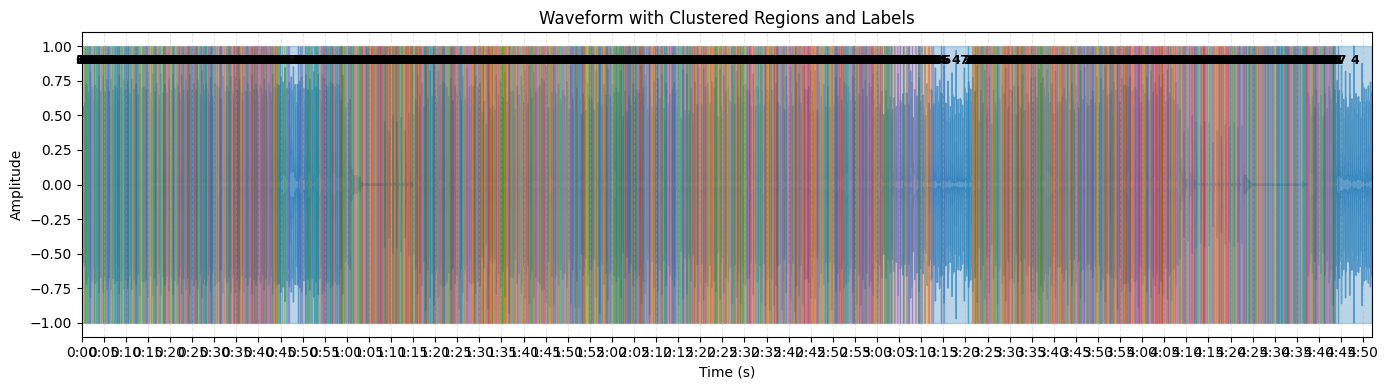

In [18]:
import librosa.display
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Plot waveform
plt.figure(figsize=(14, 4))
librosa.display.waveshow(y, sr=sr, alpha=0.6)
plt.title("Waveform with Clustered Regions and Labels")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")

# Overlay colored regions and add labels
colors = plt.cm.tab10(np.linspace(0, 1, len(set(cluster_labels))))

for start, end, cluster_id in regions:
    color = colors[cluster_id % len(colors)]
    # Draw semi-transparent block
    rect = patches.Rectangle((start, -1), end - start, 2, color=color, alpha=0.3)
    plt.gca().add_patch(rect)
    # Add cluster label in the middle of the block
    mid = (start + end) / 2
    plt.text(mid, 0.9, str(cluster_id), ha='center', va='center', fontsize=9, weight='bold')

# X-axis: time labels
plt.xticks(np.arange(0, max([r[1] for r in regions]), step=5))
plt.xlim(0, max([r[1] for r in regions]))
plt.grid(True, axis='x', linestyle='--', alpha=0.3)

plt.tight_layout()
plt.show()


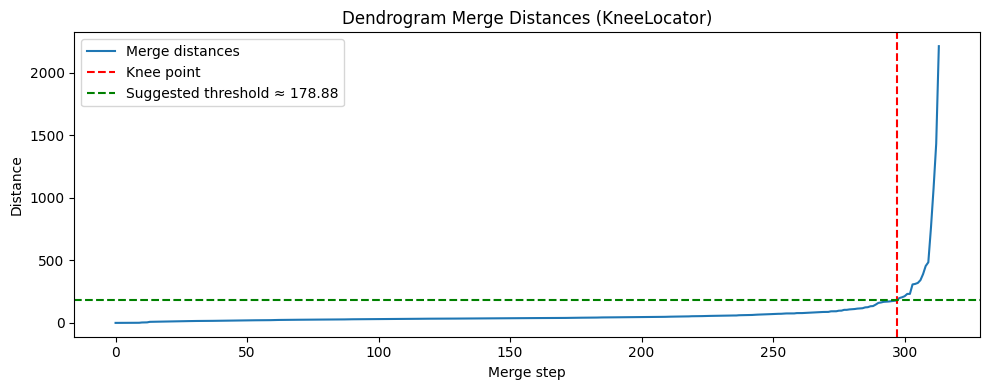

Suggested distance threshold (KneeLocator): 178.88


In [19]:
!pip install kneed --quiet
from scipy.cluster.hierarchy import linkage
from kneed import KneeLocator
import numpy as np
import matplotlib.pyplot as plt

# Step 1: Subsample for speed
step = 10
features_sampled = features[::step]

# Step 2: Linkage
Z = linkage(features_sampled, method='ward')
merge_distances = Z[:, 2]

# Step 3: Detect elbow using KneeLocator
x = np.arange(len(merge_distances))
knee = KneeLocator(x, merge_distances, curve='convex', direction='increasing')
suggested_threshold = merge_distances[knee.knee] if knee.knee is not None else None

# Step 4: Plot
plt.figure(figsize=(10, 4))
plt.plot(x, merge_distances, label="Merge distances")
if suggested_threshold:
    plt.axvline(x=knee.knee, color='r', linestyle='--', label="Knee point")
    plt.axhline(y=suggested_threshold, color='g', linestyle='--', label=f"Suggested threshold ≈ {suggested_threshold:.2f}")
else:
    plt.text(0.5, 0.5, "No knee found", transform=plt.gca().transAxes)
plt.title("Dendrogram Merge Distances (KneeLocator)")
plt.xlabel("Merge step")
plt.ylabel("Distance")
plt.legend()
plt.tight_layout()
plt.show()

print(f"Suggested distance threshold (KneeLocator): {suggested_threshold:.2f}" if suggested_threshold else "No clear knee found.")


In [20]:
import numpy as np
import librosa
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering

# Patch numpy for deprecated types
if not hasattr(np, 'complex'):
    np.complex = complex
if not hasattr(np, 'float'):
    np.float = float

# Compute Mel spectrogram with larger hop length to reduce frame count
S = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=64, fmax=8000, hop_length=2048)
log_S = librosa.power_to_db(S, ref=np.max)

# Transpose spectrogram to get feature vectors per time frame
features = log_S.T  # shape: (frames, features)

# Cluster frames based on spectral similarity
n_clusters = 5
clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
cluster_labels = clustering.fit_predict(features)

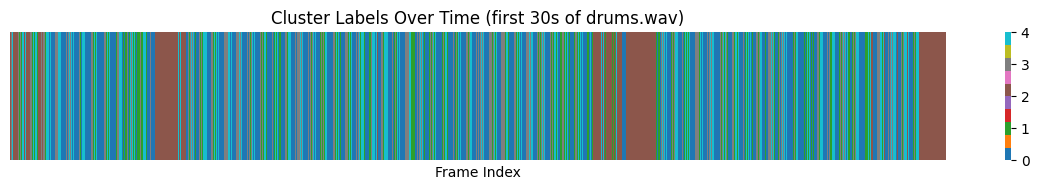

In [21]:

# Visualize clustering result as a color-coded timeline
plt.figure(figsize=(12, 2))
plt.title("Cluster Labels Over Time (first 30s of drums.wav)")
sns.heatmap([cluster_labels], cmap="tab10", cbar=True, xticklabels=False, yticklabels=False)
plt.xlabel("Frame Index")
plt.tight_layout()
plt.show()


In [22]:
!pip install pydub --quiet
# save an audio sample of each cluster (the first one, from start_time to end_time)
import os
from pydub import AudioSegment
def save_cluster_samples(df, audio_path, output_folder, stem_prefix="cluster_"):
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    audio = AudioSegment.from_wav(audio_path)
    
    for index, row in df.iterrows():
        start_time = int(row['start_time'] * 1000)  # convert to milliseconds
        end_time = int(row['end_time'] * 1000)      # convert to milliseconds
        cluster_id = row['cluster_id']
        
        sample = audio[start_time:end_time]
        sample.export(f"{output_folder}/{stem_prefix}{cluster_id}.wav", format="wav")

save_cluster_samples(df, drums_path, f"{stems_folder['output_folder']}", stem_prefix="drums_")
print(f"Save {max(df['cluster_id'])+1} cluster/s samples to {stems_folder['output_folder']}")

/home/darkangel/.pyenv/versions/3.10.17/envs/ai-light/lib/python3.10/site-packages/pydub/utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


Save 75 cluster/s samples to /home/darkangel/ai-light-show/songs/temp/htdemucs/fascination


In [23]:
# create a tuple with the cluster_id and the start_time
cluster_tuples = [(row['start_time'], int(row['cluster_id'])) for _, row in df.iterrows()]

# sort the tuples by start_time
cluster_tuples.sort(key=lambda x: x[0])

# Display the sorted tuplesx
print(cluster_tuples)


[(0.0, 4), (0.46, 34), (0.56, 61), (0.65, 4), (0.74, 5), (0.84, 17), (0.93, 21), (1.11, 71), (1.21, 62), (1.3, 4), (1.39, 70), (1.49, 32), (1.58, 50), (1.67, 21), (1.76, 22), (1.86, 0), (1.95, 4), (2.14, 51), (2.23, 42), (2.32, 70), (2.41, 49), (2.51, 34), (2.6, 61), (2.69, 4), (2.79, 5), (2.88, 17), (2.97, 70), (3.16, 71), (3.25, 62), (3.34, 4), (3.44, 49), (3.53, 32), (3.62, 37), (3.72, 70), (3.81, 22), (3.9, 0), (3.99, 4), (4.18, 51), (4.27, 42), (4.37, 21), (4.46, 49), (4.55, 34), (4.64, 61), (4.74, 4), (4.83, 5), (4.92, 17), (5.02, 21), (5.2, 71), (5.29, 62), (5.39, 4), (5.48, 49), (5.57, 32), (5.67, 50), (5.76, 21), (5.85, 22), (5.94, 0), (6.04, 4), (6.22, 3), (6.32, 42), (6.41, 70), (6.5, 49), (6.59, 34), (6.69, 61), (6.78, 4), (6.87, 51), (6.97, 17), (7.06, 70), (7.24, 71), (7.34, 62), (7.43, 4), (7.52, 1), (7.62, 32), (7.71, 37), (7.8, 70), (7.89, 22), (7.99, 0), (8.08, 4), (8.27, 3), (8.36, 37), (8.45, 21), (8.54, 1), (8.64, 34), (8.73, 61), (8.82, 4), (8.92, 51), (9.01, 17),